In [2]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import scipy.stats as stat
from scipy import optimize
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf
import community
#install pyshp
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
import os

Populating the interactive namespace from numpy and matplotlib


In [3]:
total_artist = pd.read_csv('top1000.csv', encoding="iso-8859-9")
total_artist.head()

,artist
0,Adele
1,Coldplay
2,Justin Bieber
3,Calvin Harris
4,Taylor Swift


In [4]:
total_artist_edge = pd.read_csv('total_artist_edge.csv',index_col="index")
total_artist_edge.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# change the row and column index of edge data by using artists' names
total_artist_edge.index=list(total_artist['artist'])
total_artist_edge.columns=list(total_artist['artist'])
total_artist_edge.head()

,Adele,Coldplay,Justin Bieber,Calvin Harris,Taylor Swift,Ellie Goulding,One Direction,The Weeknd,Drake,Ed Sheeran,...,Jadakiss,Jencarlos Canela,Glass Animals,Larry Hernandez,JW,Joey Montana,White Noise,Billie Holiday,Stryper,TheFatRat
Adele,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Coldplay,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Justin Bieber,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calvin Harris,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Taylor Swift,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# initiate a artist network and import all the nodes
total_artist_graph = nx.DiGraph()
total_artist_list = list(total_artist['artist'])
total_artist_graph.add_nodes_from(total_artist_list)

In [7]:
# add edges 
number_of_artist = len(total_artist)
for i in range(number_of_artist):
    for j in range(number_of_artist):
        if total_artist_edge.iloc[i][j]==1:
            total_artist_graph.add_edge(total_artist_list[i],total_artist_list[j])

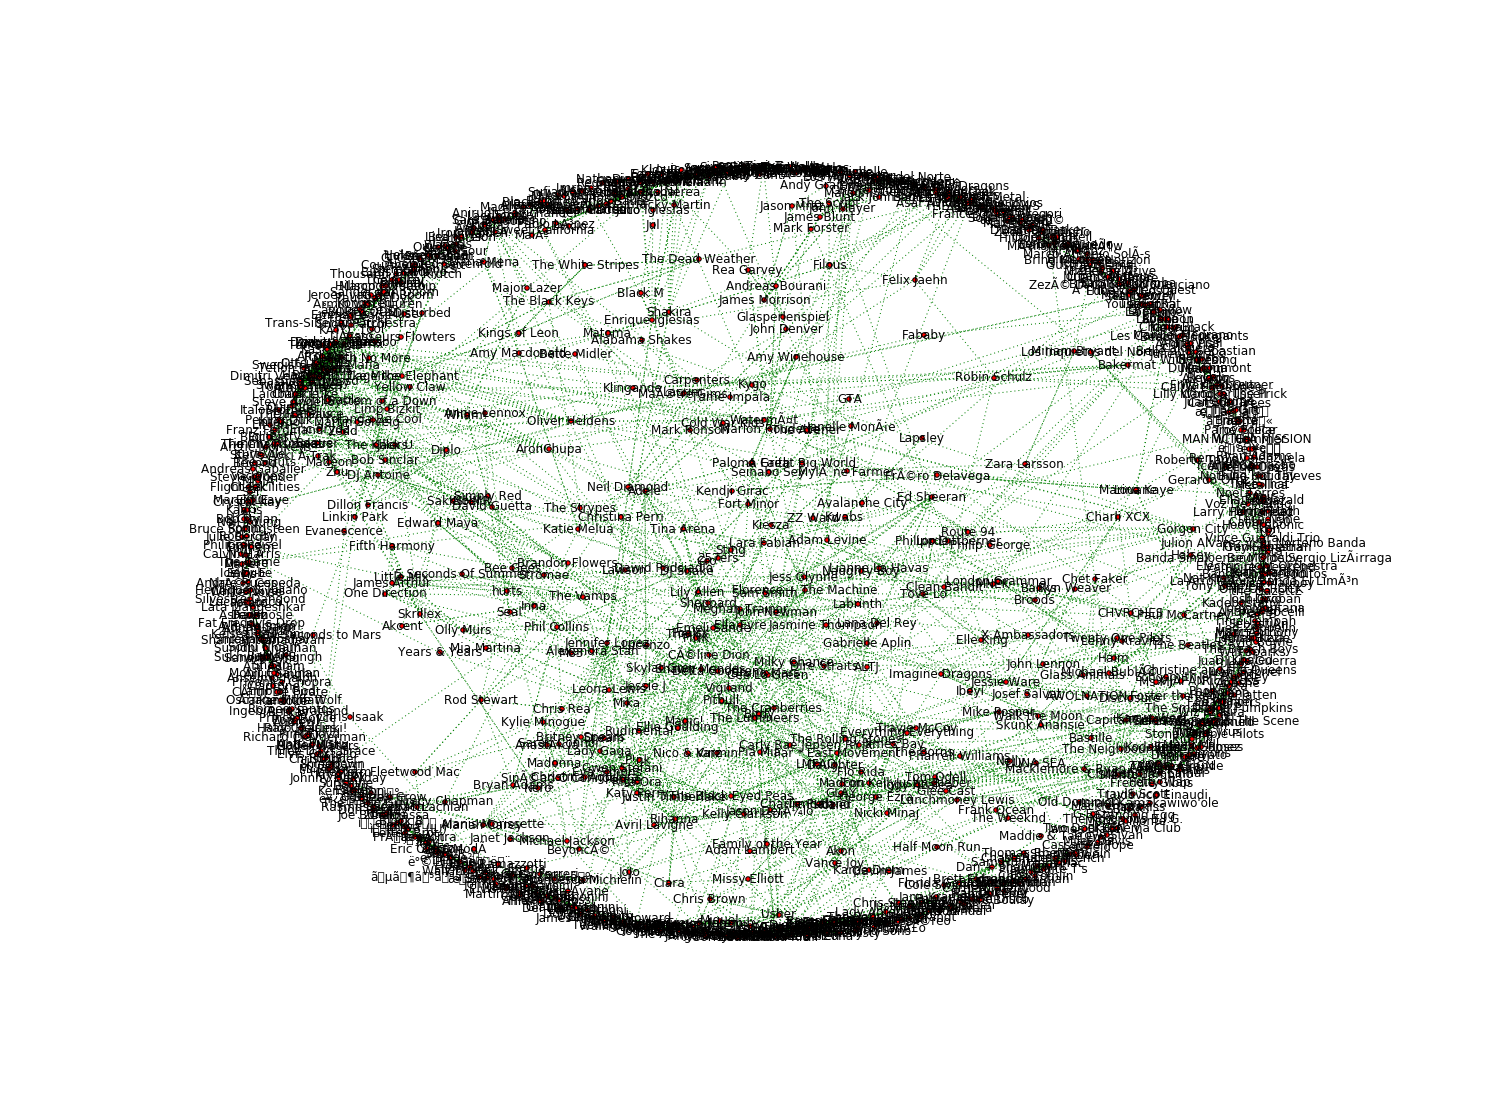

In [8]:
random.seed(2015)
plt.figure(figsize = (20,15))
nx.draw(total_artist_graph,with_labels=True,arrows=False,node_size=20,style='dotted',edge_color='green')

In [13]:
#remove loop edges from a network
def remove_loops(G):
    GU=G
    for n in GU.nodes():
        if GU.has_edge(n,n):
            GU.remove_edge(n,n)
    return GU  

In [ ]:
G

In [9]:
def as_undirected(G):
    GU=nx.Graph()
    for e in G.edges(data=True):
        if GU.has_edge(e[0],e[1]):
            GU[e[0]][e[1]]['weight']=GU[e[0]][e[1]]['weight']+e[2]['weight']
        else:
            GU.add_edge(e[0],e[1],weight=e[2]['weight'])
    nx.set_edge_attributes(GU, 'dist', 0)
    for e in GU.edges(data=True):
        GU[e[0]][e[1]]['dist']=1/float(GU[e[0]][e[1]]['weight'])
    return GU        

In [10]:
#add unit weights to unweighted network nodes
def make_weighted(G):
    WG=G
    for e in WG.edges():
        WG[e[0]][e[1]]['weight']=1
    return WG    

In [11]:
total_artist_graph = make_weighted(total_artist_graph)

In [14]:
#consider undirected version of the network without loops (for Louvain)
total_artist_graph_noloop = remove_loops(as_undirected(total_artist_graph))

In [15]:
def modularity(G,partition):
    #compute network modularity according to the given partitioning
    nodes=G.nodes()
    #compute node weights and total network weight
    if G.is_directed():
        w1=G.out_degree(weight='weight')
        w2=G.in_degree(weight='weight')
        T=1.0*sum([e[2]['weight'] for e in G.edges(data=True)])
    else:
        w1=G.degree(weight='weight')
        w2=G.degree(weight='weight')
        T=1.0*sum([(1+(e[0]!=e[1]))*e[2]['weight'] for e in G.edges(data=True)])
    M=0 #start accumulating modularity score
    for a in nodes:
        for b in nodes:
            #if (G.is_directed())|(b>=a):
                if partition[a]==partition[b]: #if nodes belong to the same community
                    #get edge weight
                    if G.has_edge(a,b):
                        e=G[a][b]['weight']
                    else:
                        e=0
                    M+=e/T-w1[a]*w2[b]/(T**2) #add modularity score for the considered edge 
    return M                

In [16]:
#partition Karate Club network using Louvain method
PC1 = community.best_partition(total_artist_graph_noloop)

In [17]:
modularity(total_artist_graph_noloop,PC1)

0.8469963293769082

In [18]:
#visualize network partitioning given node locations pos
def visualizePartition(G,partition,pos):
    N=len(G.nodes())
    pos = nx.spring_layout(G)
    plt.figure(figsize = (20,15))
    PN=max(partition.values())
    my_cmap = matplotlib.cm.hsv(np.linspace(0,1,PN+1)) #create a colormap for a given number of communities
    c=[]
    for n in G.nodes():
        c.append(1.0*partition[n])
    edges = nx.draw_networkx_edges(G,pos=pos,width=1,edge_color='black')
    nodes = nx.draw_networkx_nodes(G,pos=pos,with_labels=False,node_size=300,node_color=c,cmap='Accent')
    labels = list(partition.values())
    nx.draw_networkx_labels(G,pos,partition,font_size=20,colors='')
#    plt.colorbar(nodes)

In [20]:
PC1

{u'257ers': 31,
 u'2Cellos': 46,
 u'2NE1': 8,
 u'5 Seconds Of Summer': 2,
 u'A Great Big World': 1,
 u'A Tribe Called Quest': 12,
 u'A$AP Rocky': 6,
 u'A-Trak': 5,
 u'A.R. Rahman': 34,
 u'AC/DC': 19,
 u'AKB48': 64,
 u'ALTJ': 1,
 u'AWOLNATION': 1,
 u'Abraham Mateo': 0,
 u'Accept': 68,
 u'Adam Lambert': 10,
 u'Adam Levine': 11,
 u'Adele': 2,
 u'Adnan Sami': 34,
 u'Afrojack': 5,
 u'Agir': 70,
 u'Akcent': 5,
 u'Akon': 10,
 u'Alabama Shakes': 7,
 u'Alan Jackson': 14,
 u'Alanis Morissette': 13,
 u'Alejandro Sanz': 0,
 u'Alesso': 5,
 u'Alexandra Stan': 5,
 u'Alfredo Olivas': 27,
 u'Alka Yagnik': 34,
 u'Alkilados': 56,
 u'Alligatoah': 31,
 u'Alpa Gun': 31,
 u'Amaral': 0,
 u'Amy Macdonald': 2,
 u'Amy Winehouse': 2,
 u'Anast\xc3\xa1cia': 10,
 u'Andrea Bocelli': 45,
 u'Andreas Bourani': 35,
 u'Andr\xc3\xa9s Cepeda': 37,
 u'Andy Grammer': 11,
 u'Angus & Julia Stone': 1,
 u'Anna Naklab': 2,
 u'Annie Lennox': 19,
 u'Antonio Orozco': 0,
 u'Antti Tuisku': 57,
 u'Arcade Fire': 7,
 u'Arctic Monkeys': 7,

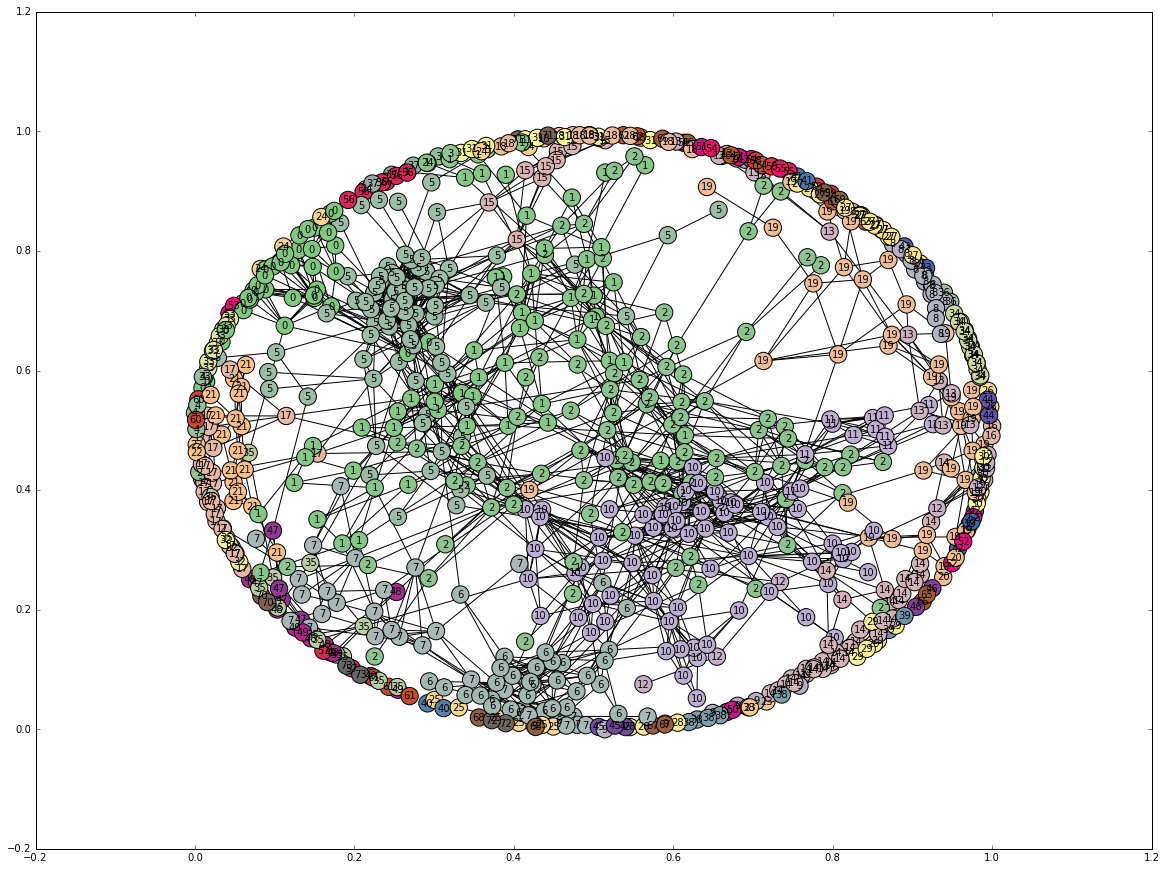

In [19]:
random.seed(2015)
visualizePartition(total_artist_graph_noloop,PC1,None)

In [1]:
type(PC1)

NameError: name 'PC1' is not defined

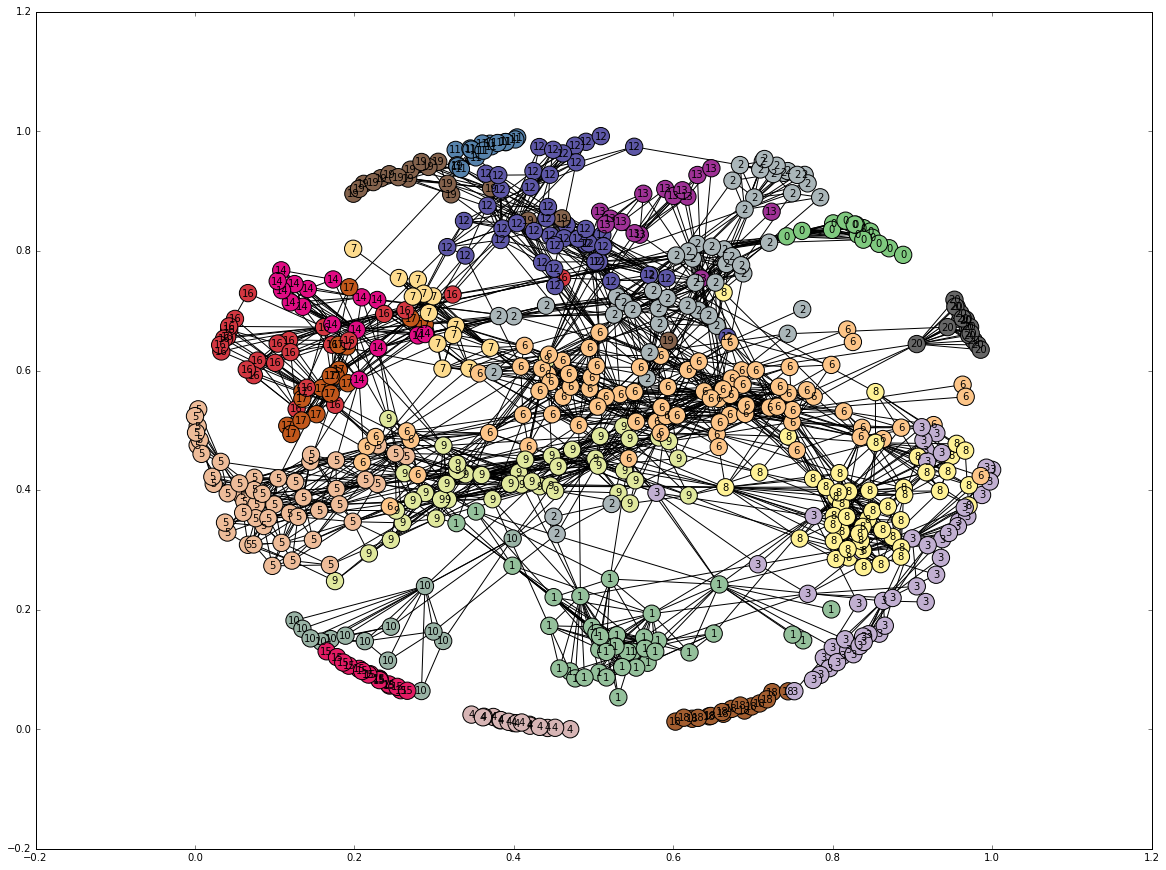

In [71]:
random.seed(2015)
visualizePartition(total_artist_graph_noloop,PC1,None)

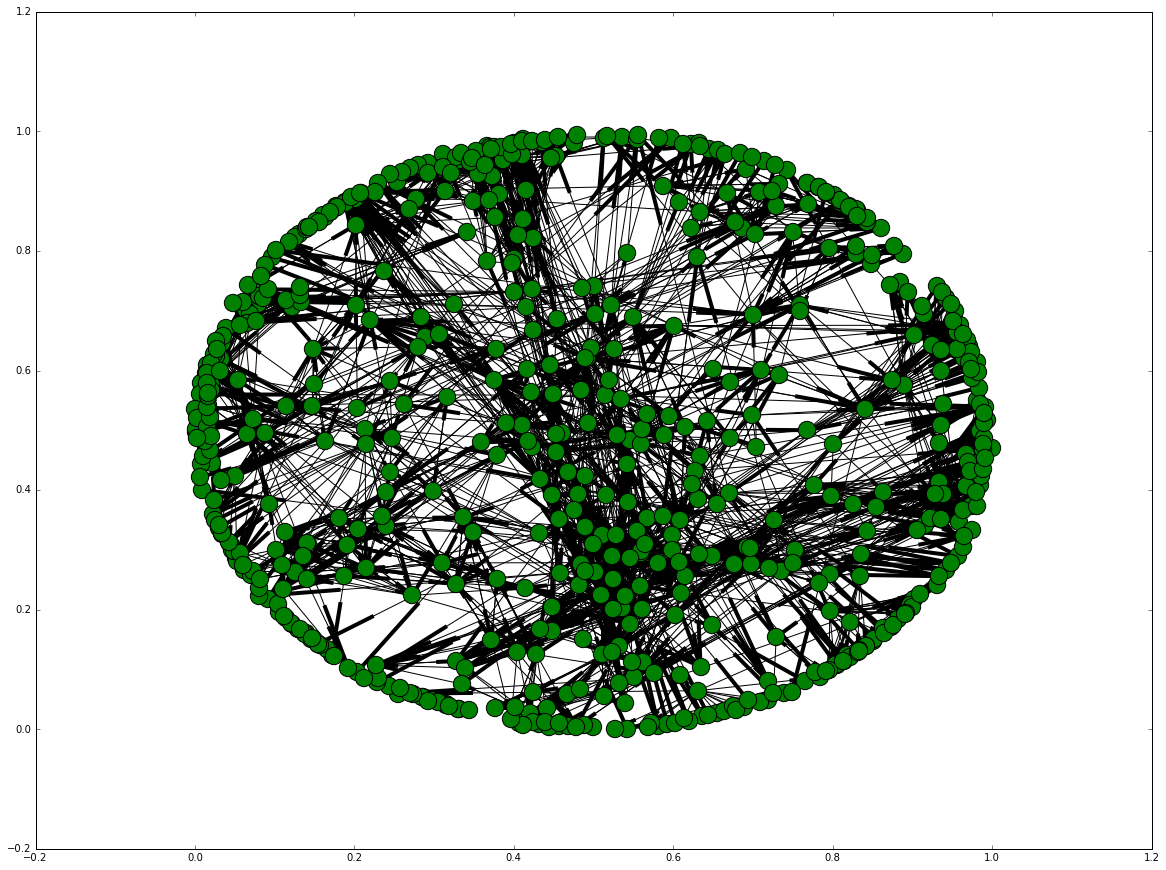

In [72]:
random.seed(2015)
plt.figure(figsize=(20,15))
G=total_artist_graph
pos = nx.spring_layout(G)
edges = nx.draw_networkx_edges(G,pos=pos,width=1,edge_color='black')
nodes = nx.draw_networkx_nodes(G,pos=pos,with_labels=True,node_size=300,node_color='g',cmap='Accent')
    

In [56]:
#interface for running compiled combo over the network G given a maximal number of communities maxcom
def getComboPartition(G,maxcom):
    #save network in net format
    nodes={}
    nodenum={}
    i=0
    #create a dictionary transforming nodes to unique numbers
    for n in G.nodes():
        nodenum[n]=i
        nodes[i]=n
        i+=1
    f = open('combo/temp.net', 'w')
    f.write('*Arcs\n')
    for e in G.edges(data=True):
        f.write('{0} {1} {2}\n'.format(nodenum[e[0]],nodenum[e[1]],e[2]['weight']))
    f.close()
    #run combo
    command='/combo/comboCPP combo/temp.net'
    if maxcom<Inf:
        command=command+' {0}'.format(maxcom)  
    os.system(command)
    #read resulting partition
    f = open('combo/temp_comm_comboC++.txt', 'r')
    i=0
    partition={}
    for line in f:
        partition[nodes[i]]=int(line)
        i+=1
    return partition    

In [58]:
PC2=getComboPartition(total_artist_graph_noloop,Inf)
random.seed(2015)
visualizePartition(total_artist_graph_noloop,PC2,None)

KeyError: u'Soulja Boy'

In [62]:
PC1

{u'1995': 18,
 u'5 Seconds Of Summer': 6,
 u'78violet': 8,
 u'A-Lee': 13,
 u'AWOLNATION': 17,
 u'Accelarator': 15,
 u'Ace Hood': 5,
 u'Adana Twins': 3,
 u'Adele': 2,
 u'Adrina Thorpe': 19,
 u'Afrojack': 1,
 u'Aggro Santos': 6,
 u'Akon': 9,
 u'Alesso': 1,
 u'Alex Clare': 6,
 u'Alex Gaudino': 1,
 u'Alex Goot': 8,
 u'Alexa Goddard': 6,
 u'Alexandra Burke': 6,
 u'Alexz Johnson': 6,
 u'Alicia Keys': 14,
 u'Alkpote': 18,
 u'Alle Farben': 3,
 u'Allison Weiss': 19,
 u'Allstar Weekend': 8,
 u'Alpha 5.20': 18,
 u'AlunaGeorge': 6,
 u'Amanda Blank': 16,
 u'Amanda Fondell': 10,
 u'Amy Kuney': 19,
 u'Amy Winehouse': 2,
 u'Andr\xe9 3000': 5,
 u'Angie Stone': 14,
 u'AniMe': 15,
 u'Anna Bergendahl': 10,
 u'Anna Sahlene': 10,
 u'Anthony Hamilton': 14,
 u'Anturage': 3,
 u'Ariana Grande': 8,
 u'Asher Roth': 5,
 u'Ashley Tisdale': 8,
 u'Athlete': 11,
 u'Atlas Genius': 17,
 u'Austin Mahone': 8,
 u'Avicii': 1,
 u'Axwell': 1,
 u'B.Traits': 6,
 u'B.o.B': 5,
 u'Bakermat': 3,
 u'Bastille': 17,
 u'Beenie Man': 16

In [46]:
PL_df = pd.DataFrame({'artist':PLtotal_artist_graph_noloop.keys(),
                      'cluster':PLtotal_artist_graph_noloop.values()})

In [ ]:
PL_df.cluster.value_counts()

In [ ]:
clusted_total_artist = total_artist.merge(PL_df, on='artist')

In [ ]:
clusted_total_artist[clusted_total_artist.artist=='Coldplay']

In [ ]:
random.seed(2015)
plt.figure(figsize=(15,12))
sub_graph = nx.subgraph(total_artist_graph,list(clusted_total_artist[clusted_total_artist.cluster==11].artist))
nx.draw(sub_graph,with_labels=True,alpha=0.5)

In [ ]:
artist.Ar